In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

In [ ]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import torch.nn.functional as F
loss_func = torch.nn.MSELoss()

In [ ]:
ratings = pd.read_pickle('/content/gdrive/My Drive/drive/data/netflix/movie_ratings_500_id.pkl')
films = pd.read_pickle('/content/gdrive/My Drive/drive/data/netflix/movie_metadata.pkl')

In [ ]:
row = []
for mid,haha in ratings.items():
    for info in haha:
        info['movie'] = mid
        row.append(info)
df_ratings = pd.DataFrame(row)
row = []
for mid,haha in films.items():
    haha['movie'] = mid
    row.append(haha)
df_movie = pd.DataFrame(row)

In [ ]:
df_movie

,director,genre,actors,title,movie
0,Peter Segal,[Comedy],"[Jack Nicholson, Adam Sandler, Marisa Tomei, W...",Anger Management,tt0305224
1,Gillian Armstrong,"[Drama, Romance, Thriller]","[Cate Blanchett, James Fleet, Abigail Cruttenden]",Charlotte Gray,tt0245046
2,Pedro Almodóvar,[Drama],"[Cecilia Roth, Marisa Paredes, Candela Peña, P...",All About My Mother,tt0185125
3,Ben Stiller,[Comedy],"[Ben Stiller, Owen Wilson, Christine Taylor, W...",Zoolander,tt0196229
4,Marc Forster,"[Biography, Drama, Family]","[Johnny Depp, Kate Winslet, Julie Christie, Du...",Finding Neverland,tt0308644
...,...,...,...,...,...
523,George Tillman Jr.,"[Biography, Drama]","[Cuba Gooding Jr., Robert De Niro, Charlize Th...",Men of Honor,tt0203019
524,Sam Mendes,"[Drama, Romance]","[Kevin Spacey, Annette Bening, Thora Birch, We...",American Beauty,tt0169547
525,Robert Rodriguez,"[Action, Adventure, Comedy]","[Alexa PenaVega, Daryl Sabara, Antonio Banderas]",Spy Kids,tt0227538
526,Nora Ephron,"[Comedy, Fantasy, Romance]","[Nicole Kidman, Will Ferrell, Shirley MacLaine...",Bewitched,tt0374536


In [ ]:
a = df_movie['director'].value_counts()[df_movie['director'].value_counts() >= 2]
df_movie = df_movie[df_movie['director'].isin(list(a.index))]
df_movie.index = range(len(df_movie))

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
final = pd.merge(df_movie,df_ratings,on='movie')
a = final['user_id'].value_counts()[final['user_id'].value_counts() >= 10]
final = final[final['user_id'].isin(list(a.index))]
final.index = range(len(final))
hehe = final.copy()
del hehe['title']
del hehe['user_rating_date']

In [ ]:
movie = dict()
for i in range(df_movie.shape[0]):
    m = df_movie['movie'][i]
    movie.setdefault(m,dict())
    movie[m]['director'] = df_movie['director'][i]
    movie[m]['genre'] = df_movie['genre'][i]
    movie[m]['actors'] = df_movie['actors'][i]
    movie[m]['title'] = df_movie['title'][i]

In [ ]:
def map_aspect_values_to_movies(x):
    (film, meta), aspect = x
    aspects = dict()
    if aspect == "director":
        aspects[meta[aspect]] = 1
    else:
        for g in meta[aspect]:
            aspects[g] = 1
    return film, meta, aspects


def dict_movie_aspect(paper_films, aspect):
    paper_films_aspect_prepended = map(
        lambda e: (e, aspect), list(paper_films.items()))
    aspect_dict = dict()
    with ProcessPoolExecutor(max_workers=THREADS) as executor:
        results = executor.map(map_aspect_values_to_movies,
                               paper_films_aspect_prepended)
    for film, meta, aspects in results:
        aspect_dict[film + "_" + meta["title"]] = aspects
    return aspect_dict

In [ ]:
movie_genres = dict_movie_aspect(movie, "genre")
movie_directors = dict_movie_aspect(movie,'director')
movie_actors = dict_movie_aspect(movie,'actors')
actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
genres = pd.DataFrame.from_dict(movie_genres,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [ ]:
actors_dict = dict(zip(actors, range(len(actors))))
directors_dict = dict(zip(directors, range(
    len(actors), len(actors) + len(directors))))
genres_dict = dict(zip(genres, range(
    len(actors) + len(directors), len(actors) + len(directors) + len(genres))))
max(actors_dict.values()),max(directors_dict.values()),max(genres_dict.values())

(507, 608, 626)

In [ ]:
def change_director(x):
    return [itemgetter(x)(directors_dict)]


def change_actor(x):
    return change_list((itemgetter(*x)(actors_dict)))


def change_genre(x):
    qunima = itemgetter(*x)(genres_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_list(x):
    return list(x)

In [ ]:
hehe['director'] = hehe['director'].map(change_director)
hehe['actors'] = hehe['actors'].map(change_actor)
hehe['genre'] = hehe['genre'].map(change_genre)

In [ ]:
hehe = hehe[['user_id','movie','actors','director','genre','user_rating']]
hehe['user_rating'] = hehe['user_rating'].astype('float')

In [ ]:
le = LabelEncoder()
y_user = le.fit_transform(hehe['user_id'])
hehe['user_id'] = y_user

y_movie = le.fit_transform(hehe['movie'])
hehe['movie'] = y_movie


In [ ]:
print("The number of aspects is {}".format(max(genres_dict.values()) + 1))
print("The number of users is {}".format(max(hehe['user_id'])+1))

The number of aspects is 627
The number of users is 2802


In [ ]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.2)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base).to(DEVICE)
    actors_base = aspects(actor_base)  # 3 * 8
    #actors_base = actors_base + items[first % 128].unsqueeze(1)
    #actors_base = F.dropout(actors_base, p=rate, training=True)
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val).to(DEVICE)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)
        

    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        
        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [ ]:
def RMSE(data, model,batch_size,items):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
#     items_index = data.iloc[:, 0].values
#     items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    return rmse ** 0.5,mae, cnm

In [ ]:
def train(lr, dim, reg, batch_size, num_epochs, data, test):
    model = aspect_augumentation(2802, 627, 3, dim).to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, threshold=0.005, threshold_mode='abs')
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()
        num_example = len(data)
        indices = list(range(num_example))
        for i in tqdm(range(0, num_example, batch_size)):
            optimizer.zero_grad()
            indexs = indices[i:min(i+batch_size, num_example)]
            users_index = data.iloc[:, 0].loc[indexs].values
            users = torch.LongTensor(users_index).to(DEVICE)
            items_index = data.iloc[:, 0].values
            items = torch.LongTensor(items_index).to(DEVICE)
            actors_id = data.iloc[:, 2].loc[indexs]
            actors_id.index = range(len(actors_id))
            directors_id = data.iloc[:, 3].loc[indexs]
            directors_id.index = range(len(directors_id))
            genres_id = data.iloc[:, 4].loc[indexs]
            genres_id.index = range(len(genres_id))
            rating = torch.FloatTensor(
                data.iloc[:, 5].loc[indexs].values).to(DEVICE)
            prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = model(
                users, actors_id, directors_id, genres_id)

            err = loss_func(prediction, rating) + reg * ((model.user_factors.weight*model.user_factors.weight).sum() +
                                                         (model.entity_factors.weight*model.entity_factors.weight).sum() +
                                                         (model.relation_k.weight*model.relation_k.weight).sum())

            err.backward()
            optimizer.step()
        t2 = time.time()
        rmse, mae,cnm = RMSE(test, model,batch_size,items)
        scheduler.step(rmse)
        print("Epoch: ", epoch, " Loss: ", err, " RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Time consumed is:", t2-t1)
    return rmse, mae, model, cnm

In [ ]:
trainset = hehe.sample(frac=0.8, random_state=0, axis=0)
trainset.index = range(len(trainset))
testset = hehe[~hehe.index.isin(trainset.index)]
testset.index = range(len(testset))
rate = 0.0

In [ ]:
def grid(lrs, dims, regs, batch_sizes, num_epochs, data, test):
    res = []
    models = []
    qnm = []
    for lr in lrs:
        for dim in dims:
            for reg in regs:
                for batch_size in batch_sizes:
                    rmse, mae,model,cnm = train(
                        lr, dim, reg, batch_size, num_epochs, data, test)
                    res.append(rmse)
                    res.append(mae)
                    models.append(model)
                    qnm.append(cnm)
    return res, models,qnm

In [ ]:
lrs = [1e-2]
dims = [8]
regs = [1e-6]
batch_sizes = [256]
num_epochs = 50
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,trainset,testset)

100%|██████████| 268/268 [00:40<00:00,  6.58it/s]


Epoch:  0  Loss:  tensor(3.7389, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.6397, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2850, grad_fn=<L1LossBackward0>)
Time consumed is: 40.74706840515137


100%|██████████| 268/268 [00:42<00:00,  6.28it/s]


Epoch:  1  Loss:  tensor(1.2640, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0617, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8354, grad_fn=<L1LossBackward0>)
Time consumed is: 42.6899151802063


100%|██████████| 268/268 [00:41<00:00,  6.53it/s]


Epoch:  2  Loss:  tensor(0.9200, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9752, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7700, grad_fn=<L1LossBackward0>)
Time consumed is: 41.054805755615234


100%|██████████| 268/268 [00:40<00:00,  6.55it/s]


Epoch:  3  Loss:  tensor(0.8400, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9513, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7514, grad_fn=<L1LossBackward0>)
Time consumed is: 40.89973759651184


100%|██████████| 268/268 [00:39<00:00,  6.81it/s]


Epoch:  4  Loss:  tensor(0.8113, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9416, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7432, grad_fn=<L1LossBackward0>)
Time consumed is: 39.361757040023804


100%|██████████| 268/268 [00:38<00:00,  6.99it/s]


Epoch:  5  Loss:  tensor(0.7988, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9360, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7383, grad_fn=<L1LossBackward0>)
Time consumed is: 38.37834882736206


100%|██████████| 268/268 [00:39<00:00,  6.74it/s]


Epoch:  6  Loss:  tensor(0.7866, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9311, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7340, grad_fn=<L1LossBackward0>)
Time consumed is: 39.746039390563965


100%|██████████| 268/268 [00:38<00:00,  6.99it/s]


Epoch:  7  Loss:  tensor(0.7679, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9258, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7293, grad_fn=<L1LossBackward0>)
Time consumed is: 38.340455055236816


100%|██████████| 268/268 [00:39<00:00,  6.79it/s]


Epoch:  8  Loss:  tensor(0.7411, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9198, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7241, grad_fn=<L1LossBackward0>)
Time consumed is: 39.503592014312744


100%|██████████| 268/268 [00:38<00:00,  7.00it/s]


Epoch:  9  Loss:  tensor(0.7102, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9133, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7183, grad_fn=<L1LossBackward0>)
Time consumed is: 38.27863049507141


100%|██████████| 268/268 [00:39<00:00,  6.77it/s]


Epoch:  10  Loss:  tensor(0.6816, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9068, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7123, grad_fn=<L1LossBackward0>)
Time consumed is: 39.60263204574585


100%|██████████| 268/268 [00:38<00:00,  7.03it/s]


Epoch:  11  Loss:  tensor(0.6607, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9005, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7064, grad_fn=<L1LossBackward0>)
Time consumed is: 38.160974740982056


100%|██████████| 268/268 [00:38<00:00,  6.90it/s]


Epoch:  12  Loss:  tensor(0.6333, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8944, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7005, grad_fn=<L1LossBackward0>)
Time consumed is: 38.844255208969116


100%|██████████| 268/268 [00:38<00:00,  6.97it/s]


Epoch:  13  Loss:  tensor(0.6186, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8888, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6948, grad_fn=<L1LossBackward0>)
Time consumed is: 38.46560788154602


100%|██████████| 268/268 [00:38<00:00,  6.97it/s]


Epoch:  14  Loss:  tensor(0.5944, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8835, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6895, grad_fn=<L1LossBackward0>)
Time consumed is: 38.437018632888794


100%|██████████| 268/268 [00:39<00:00,  6.73it/s]


Epoch:  15  Loss:  tensor(0.5793, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8785, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6844, grad_fn=<L1LossBackward0>)
Time consumed is: 39.835015535354614


100%|██████████| 268/268 [00:38<00:00,  6.94it/s]


Epoch:  16  Loss:  tensor(0.5986, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8741, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6798, grad_fn=<L1LossBackward0>)
Time consumed is: 38.61941623687744


100%|██████████| 268/268 [00:39<00:00,  6.74it/s]


Epoch:  17  Loss:  tensor(0.5881, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8703, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6760, grad_fn=<L1LossBackward0>)
Time consumed is: 39.79235053062439


100%|██████████| 268/268 [00:38<00:00,  6.99it/s]


Epoch:  18  Loss:  tensor(0.5707, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8669, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6724, grad_fn=<L1LossBackward0>)
Time consumed is: 38.37879991531372


100%|██████████| 268/268 [00:39<00:00,  6.75it/s]


Epoch:  19  Loss:  tensor(0.5533, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8640, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6693, grad_fn=<L1LossBackward0>)
Time consumed is: 39.70633888244629


100%|██████████| 268/268 [00:38<00:00,  6.94it/s]


Epoch:  20  Loss:  tensor(0.5410, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6669, grad_fn=<L1LossBackward0>)
Time consumed is: 38.613059759140015


100%|██████████| 268/268 [00:40<00:00,  6.69it/s]


Epoch:  21  Loss:  tensor(0.5318, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8597, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6643, grad_fn=<L1LossBackward0>)
Time consumed is: 40.0429847240448


100%|██████████| 268/268 [00:38<00:00,  6.91it/s]


Epoch:  22  Loss:  tensor(0.5244, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8586, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6627, grad_fn=<L1LossBackward0>)
Time consumed is: 38.77608060836792


100%|██████████| 268/268 [00:39<00:00,  6.71it/s]


Epoch:  23  Loss:  tensor(0.5327, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8575, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6612, grad_fn=<L1LossBackward0>)
Time consumed is: 39.9337158203125


100%|██████████| 268/268 [00:38<00:00,  6.92it/s]


Epoch:  24  Loss:  tensor(0.5181, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8561, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6601, grad_fn=<L1LossBackward0>)
Time consumed is: 38.71811628341675


100%|██████████| 268/268 [00:38<00:00,  6.99it/s]


Epoch:  25  Loss:  tensor(0.5230, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8556, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6589, grad_fn=<L1LossBackward0>)
Time consumed is: 38.37137007713318


100%|██████████| 268/268 [00:39<00:00,  6.78it/s]


Epoch:  26  Loss:  tensor(0.5029, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8542, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6577, grad_fn=<L1LossBackward0>)
Time consumed is: 39.51225304603577


100%|██████████| 268/268 [00:38<00:00,  7.03it/s]


Epoch:  27  Loss:  tensor(0.4996, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8528, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6564, grad_fn=<L1LossBackward0>)
Time consumed is: 38.15871524810791


100%|██████████| 268/268 [00:39<00:00,  6.83it/s]


Epoch:  28  Loss:  tensor(0.4981, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8520, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6552, grad_fn=<L1LossBackward0>)
Time consumed is: 39.253901958465576


100%|██████████| 268/268 [00:38<00:00,  7.00it/s]


Epoch:  29  Loss:  tensor(0.4901, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8501, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6536, grad_fn=<L1LossBackward0>)
Time consumed is: 38.31525659561157


100%|██████████| 268/268 [00:39<00:00,  6.82it/s]


Epoch:  30  Loss:  tensor(0.4859, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8496, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6528, grad_fn=<L1LossBackward0>)
Time consumed is: 39.33275055885315


100%|██████████| 268/268 [00:38<00:00,  7.05it/s]


Epoch:  31  Loss:  tensor(0.4866, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8491, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6514, grad_fn=<L1LossBackward0>)
Time consumed is: 38.04550075531006


100%|██████████| 268/268 [00:39<00:00,  6.83it/s]


Epoch:  32  Loss:  tensor(0.4979, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8487, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6504, grad_fn=<L1LossBackward0>)
Time consumed is: 39.24691152572632


100%|██████████| 268/268 [00:37<00:00,  7.09it/s]


Epoch:  33  Loss:  tensor(0.4800, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6495, grad_fn=<L1LossBackward0>)
Time consumed is: 37.797823667526245


100%|██████████| 268/268 [00:39<00:00,  6.76it/s]


Epoch:  34  Loss:  tensor(0.4776, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8477, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6486, grad_fn=<L1LossBackward0>)
Time consumed is: 39.652132749557495


100%|██████████| 268/268 [00:38<00:00,  7.05it/s]


Epoch:  35  Loss:  tensor(0.4842, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6474, grad_fn=<L1LossBackward0>)
Time consumed is: 38.03400254249573


100%|██████████| 268/268 [00:38<00:00,  7.04it/s]


Epoch:  36  Loss:  tensor(0.4713, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8469, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6463, grad_fn=<L1LossBackward0>)
Time consumed is: 38.08831787109375


100%|██████████| 268/268 [00:39<00:00,  6.82it/s]


Epoch:  37  Loss:  tensor(0.4666, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8463, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6451, grad_fn=<L1LossBackward0>)
Time consumed is: 39.289135694503784


100%|██████████| 268/268 [00:38<00:00,  7.04it/s]


Epoch:  38  Loss:  tensor(0.4353, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8326, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6314, grad_fn=<L1LossBackward0>)
Time consumed is: 38.09621977806091


100%|██████████| 268/268 [00:39<00:00,  6.84it/s]


Epoch:  39  Loss:  tensor(0.4300, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8311, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6293, grad_fn=<L1LossBackward0>)
Time consumed is: 39.17782115936279


100%|██████████| 268/268 [00:37<00:00,  7.13it/s]


Epoch:  40  Loss:  tensor(0.4266, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8305, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6283, grad_fn=<L1LossBackward0>)
Time consumed is: 37.60648560523987


100%|██████████| 268/268 [00:39<00:00,  6.84it/s]


Epoch:  41  Loss:  tensor(0.4241, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8301, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6275, grad_fn=<L1LossBackward0>)
Time consumed is: 39.167654275894165


100%|██████████| 268/268 [00:37<00:00,  7.19it/s]


Epoch:  42  Loss:  tensor(0.4222, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8299, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6269, grad_fn=<L1LossBackward0>)
Time consumed is: 37.29906439781189


100%|██████████| 268/268 [00:39<00:00,  6.84it/s]


Epoch:  43  Loss:  tensor(0.4206, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8297, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6263, grad_fn=<L1LossBackward0>)
Time consumed is: 39.20238518714905


100%|██████████| 268/268 [00:37<00:00,  7.06it/s]


Epoch:  44  Loss:  tensor(0.4189, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8296, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6258, grad_fn=<L1LossBackward0>)
Time consumed is: 37.96918821334839


100%|██████████| 268/268 [00:38<00:00,  7.02it/s]


Epoch:  45  Loss:  tensor(0.3996, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8262, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6220, grad_fn=<L1LossBackward0>)
Time consumed is: 38.20493721961975


100%|██████████| 268/268 [00:37<00:00,  7.08it/s]


Epoch:  46  Loss:  tensor(0.3965, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8256, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6212, grad_fn=<L1LossBackward0>)
Time consumed is: 37.86972379684448


100%|██████████| 268/268 [00:37<00:00,  7.10it/s]


Epoch:  47  Loss:  tensor(0.3946, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8253, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6207, grad_fn=<L1LossBackward0>)
Time consumed is: 37.78286409378052


100%|██████████| 268/268 [00:39<00:00,  6.84it/s]


Epoch:  48  Loss:  tensor(0.3931, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8252, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6204, grad_fn=<L1LossBackward0>)
Time consumed is: 39.21175742149353


100%|██████████| 268/268 [00:38<00:00,  7.04it/s]


Epoch:  49  Loss:  tensor(0.3919, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8251, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6201, grad_fn=<L1LossBackward0>)
Time consumed is: 38.070815324783325


In [ ]:
!pip install umap-learn
!pip install "umap-learn[plot]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 20.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b3a7f76ac0b23333a055f78035b1d2b46357f082f7de54b5f5de288dc1f3b2b9
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=8ffc93f747d5d5c61404b7ca10c2eca7e7085388b3f369fcf1af540f5f94deea
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 799 kB/s 
     |████████████████████████████████| 76 kB 6.3 MB/s 


In [ ]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
from umap import UMAP
import umap.plot

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


def xiba(hehe,model):
    users_index = hehe.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = hehe.iloc[:, 2]
    directors_id = hehe.iloc[:, 3]
    genres_id = hehe.iloc[:, 4]
    rating = torch.FloatTensor(
        hehe.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres, cnm = model(users, actors_id, directors_id, genres_id)
    return prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm

In [50]:
prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = xiba(testset,models_reg[0])

In [34]:
rating = torch.FloatTensor(
        testset.iloc[:, 5].values)
rating

tensor([4., 3., 3.,  ..., 5., 2., 5.])

In [95]:
i = 17121 ## the index of user-item interaction in the testset
dict_actors = {v:k for k,v in actors_dict.items()}
dict_directors = {v:k for k,v in directors_dict.items()}
dict_genres = {v:k for k,v in genres_dict.items()}


importance = scores.cpu().detach().numpy()
arg_actors = cnm[0][i].detach().numpy()
arg_directors = cnm[1][i].detach().numpy()
arg_genres = cnm[2][i].detach().numpy()

info = testset.iloc[i]
movies = info['movie']
actors_id = info['actors']
directors_id = info['director']
genres_id = info['genre']

actors_name = itemgetter(*actors_id)(dict_actors)
directors_name = itemgetter(*directors_id)(dict_directors)

genres_name = itemgetter(*genres_id)(dict_genres)

{('Christian Bale', 224): Text(1.5, 2.0, '0.0'),
 ('Jennifer Jason Leigh', 224): Text(1.5, 4.0, '0.0'),
 ('Aitana Sánchez-Gijón', 224): Text(4.0, 6.0, '0.0'),
 ('Brad Anderson', 224): Text(6.0, 4.0, '0.0'),
 ('Drama', 224): Text(6.0, 2.0, '2.08'),
 ('Thriller', 224): Text(4.0, 2.0, '2.17')}

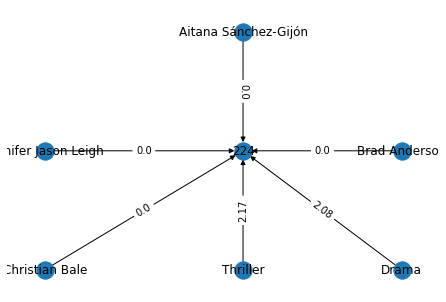

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

G.add_node(actors_name[0],pos=(-1,0))
G.add_node(actors_name[1],pos=(-1,4))
G.add_node(actors_name[2],pos=(4,8))
G.add_node(directors_name,pos=(8,4))
G.add_node(genres_name[0],pos=(8,0))
G.add_node(genres_name[1],pos=(4,0))
G.add_node(movies,pos=(4,4))


G.add_edge(actors_name[0],movies,weight=round(importance[i][0] * (max(arg_actors[0],0))/ 3,2))
G.add_edge(actors_name[1],movies,weight=round(importance[i][0] *(max(arg_actors[1],0)) / 3,2))
G.add_edge(actors_name[2],movies,weight=round(importance[i][0] *(max(arg_actors[2],0)) / 3,2))
G.add_edge(directors_name,movies,weight=round(importance[i][1] *(max(arg_directors[0],0)) / 1,2))
G.add_edge(genres_name[0],movies,weight=round(importance[i][2] *(float(arg_genres[0])) / 2,2))
G.add_edge(genres_name[1],movies,weight=round(importance[i][2] *(float(arg_genres[1])) / 2,2))


pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [94]:
testset

,user_id,movie,actors,director,genre,user_rating
0,99,140,"[153, 255, 69, 456, 450]",[604],"[610, 616, 613]",4.0
1,2307,140,"[153, 255, 69, 456, 450]",[604],"[610, 616, 613]",3.0
2,1066,140,"[153, 255, 69, 456, 450]",[604],"[610, 616, 613]",3.0
3,2208,140,"[153, 255, 69, 456, 450]",[604],"[610, 616, 613]",4.0
4,2106,140,"[153, 255, 69, 456, 450]",[604],"[610, 616, 613]",4.0
...,...,...,...,...,...,...
17117,1336,224,"[237, 264, 507]",[606],"[610, 617]",4.0
17118,670,224,"[237, 264, 507]",[606],"[610, 617]",1.0
17119,1650,224,"[237, 264, 507]",[606],"[610, 617]",5.0
17120,63,224,"[237, 264, 507]",[606],"[610, 617]",2.0


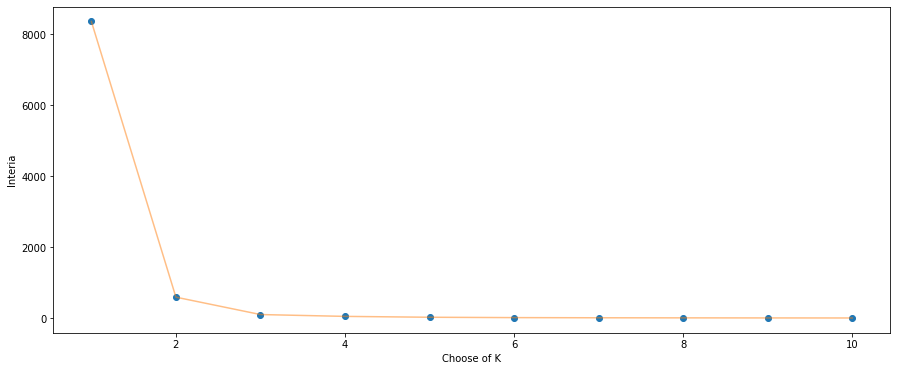

In [79]:
X = scores.cpu().data.numpy()
from sklearn.cluster import KMeans
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(X)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [ ]:
### It can be observed that after 3, even if we increase K, the effect of clustering does not improve, therefore, the number of clusters is chosen to be 3

Starting compute t-SNE Embedding...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


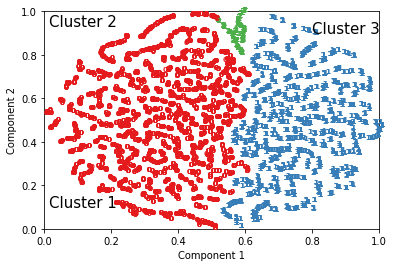

In [81]:
estimators = KMeans(n_clusters=3)
estimators.fit(X)
labele = estimators.labels_
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 17122, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

reslut = ts.fit_transform(data)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)



fig = plt.figure()
ax = plt.subplot(111)
for i in range(reslut.shape[0]):
    plt.text(reslut[i, 0], reslut[i, 1], str(label[i]), color=plt.cm.Set1(label[i]),
                 fontdict={'weight': 'bold', 'size': 7})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.text(0.015,0.93, 'Cluster 2', fontsize=15)
plt.text(0.015,0.10, 'Cluster 1', fontsize=15)
plt.text(0.80,0.9, 'Cluster 3', fontsize=15)
plt.xticks()
plt.yticks()
plt.show()

In [ ]:
### As a matter of fact, other methods of cluster such as UMAP can be applied.

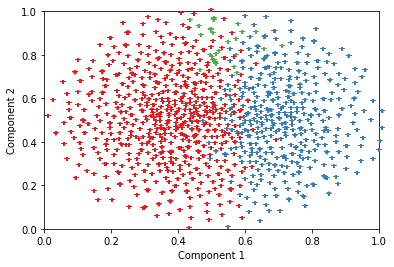

In [88]:
mapper = UMAP().fit(X)
reslut = UMAP().fit_transform(X)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)
fig = plt.figure()
ax = plt.subplot(111)
for i in range(reslut.shape[0]):
    plt.text(reslut[i, 0], reslut[i, 1], '+', color=plt.cm.Set1(labele[i]),
                 fontdict={'weight': 'bold', 'size': 7})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xticks()
plt.yticks()
plt.show()

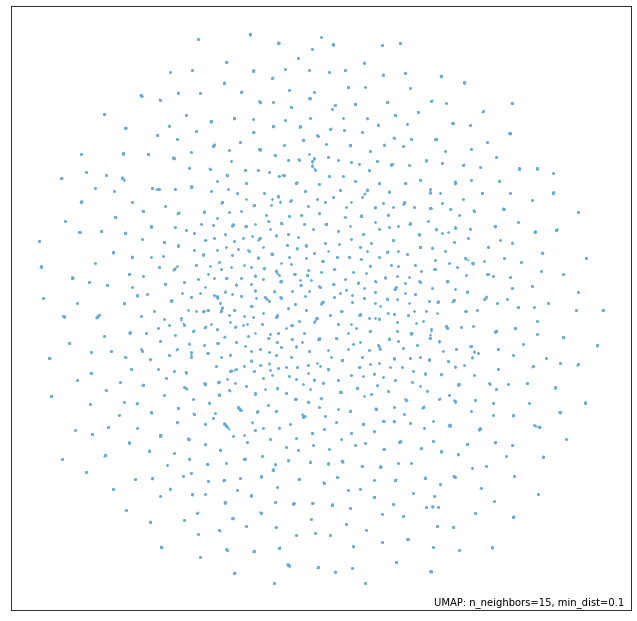

In [89]:
umap.plot.points(mapper)

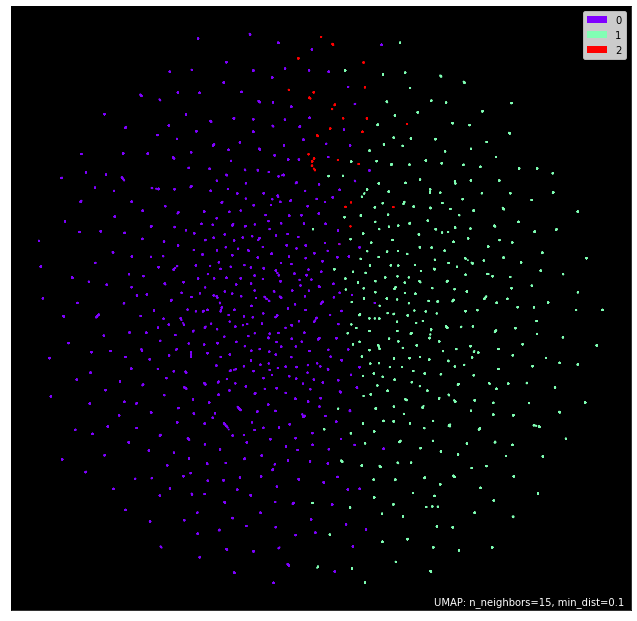

In [90]:
umap.plot.points(mapper, labels=labele, color_key_cmap='Paired', theme='fire')


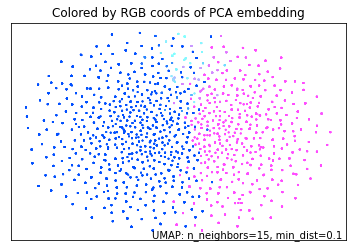

In [91]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

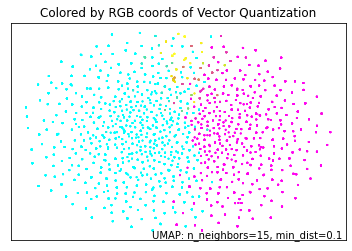

In [92]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')
